In [ ]:
draft: false
weight: 3
title: Link Business Points into Community Polygons
description: A demonstration of using Census data and geographically joining points into polygons.
toc: false
show_input: show
section: notebooks
authors:
- name: Eric Busboom
github: 


# Link Businesses to Communities


One of the challenges of working with geographic data is presenting it in forms that can communicate important relationships. For a lot of geographic data relates to urban areas, the structutre that people care about most is related to political boundaries: cities, districts or neighborhoods. Cities and towns are sensible units when they are small, but for large cities, people are more likely to be interested in neighborhoods. 

In San Diego County, the City of San Diego has well-defined communities, most of the other cities in the county are relatively small enough to consider without sub-division. There are also some communities defined in the county. All of these datasets, with geographic boundaries, are published by [SANGIS](http://sangis.org), and they are collected in the dataset [sangis.org-communities-2018](https://data.sandiegodata.org/dataset/sangis-org-communities-2018), published byt the [San Diego Regional Data Library](http://sandiegodata.org).

This notebook demonstrates how to load these geographic datasets and do a geographic perge from geographic points, to classify the points as belonging to a particularly city or community. 

Running this notebook will require, in additional to the usual modules: 

* geopandas
* publicdata
* rtree

RTree will fail unless ``libspatialindex`` is installed, which you might do on Mac Os X with : 

```
  $ brew install spatialindex
```

In [28]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import metapack as mp
from rowgenerators import parse_app_url
%matplotlib inline

Here is the dataset from the data library. [Visit the data repository page](https://data.sandiegodata.org/dataset/sangis-org-communities-2018) and copy the code from the section "Loading the ZIP Package"

In [2]:
pkg = mp.open_package('http://library.metatab.org/sangis.org-communities-2018-1.zip')
pkg

In [3]:
# The .geoframe() method gives us a Geopandas geographic dataframe. 
com = pkg.resource('communities').geoframe()

Geopandas has greate plotting support for a quick look at the file. Note that the ``column`` parameter sets the column that will be used to determine the color of the region. Here is of the regions in the file colored differently. 

In [4]:
com.plot(column='code')

Now let's get the active businesses dataset from 

In [5]:
businesses = pd.read_csv('http://seshat.datasd.org/ttcs/sd_active_businesses_datasd.csv')

In [6]:
businesses.head().T

,0,1,2,3,4
account_key,2017014278,2017013866,2017013873,2017013871,2017013870
address_str,10640 scripps ranch blvd,5085 september st,827 beryl st,2704 boston ave,1502 mesa brook st
apt_suite,101,NaN,NaN,NaN,NaN
bus_start_dt,2017-08-23,2015-09-01,2015-09-01,2015-09-01,2015-09-01
business_owner_name,miriam chor freitas,robert burke,robert doll,jose m espinozanaranjo & maria m dadaespinoza,feliz h blanco & idalia contreras ochoa
business_phone,(858) 217-5770,NaN,NaN,NaN,NaN
city,san diego,san diego,san diego,san diego,san diego
creation_dt,2017-09-27,2017-09-27,2017-09-27,2017-09-27,2017-09-27
doing_bus_as_name,miriam chor freitas lcsw,robert burke,robert doll,jose m espinozanaranjo & maria m dadaespinoza,feliz h blanco & idalia contreras ochoa
expiration_dt,2018-08-31,2018-08-31,2018-08-31,2018-08-31,2018-08-31


In [7]:
## Create a new GeoPandas frame, converting the targetlongitude and targetlatitude
## colums to a Shapely Point and assigning it to the frame's geometry
from shapely.geometry import Point

bus_g = gpd.GeoDataFrame(businesses, geometry=
                        [Point(x,y) for x,y in zip(businesses.lon, businesses.lat)])

In [45]:
from geopandas import gpd 

# Quickly restrict dataset to only those in the county; there are a lot of points in NorCal and the US
x_min, y_min, x_max, y_max = com.geometry.total_bounds
_1 = bus_g[ (bus_g.lon <= x_max) &  (bus_g.lat <= y_max) & (bus_g.lon >= x_min) &  (bus_g.lat >= y_min)  ]

business_comm = gpd.sjoin(_1, com, op='intersects') # Probably will be slow
business_comm

,account_key,address_str,apt_suite,bus_start_dt,business_owner_name,business_phone,city,creation_dt,doing_bus_as_name,expiration_dt,...,pmb_box,po_box,state,zip,BID,geometry,index_right,type,name,code
0,2017014278,10640 scripps ranch blvd,101,2017-08-23,miriam chor freitas,(858) 217-5770,san diego,2017-09-27,miriam chor freitas lcsw,2018-08-31,...,NaN,NaN,CA,92131-1095,NaN,POINT (-117.1103214 32.9119358),71,city,SAN DIEGO,SD
1,2017013866,5085 september st,NaN,2015-09-01,robert burke,NaN,san diego,2017-09-27,robert burke,2018-08-31,...,NaN,NaN,CA,92110-1222,NaN,POINT (-117.187049 32.78008),71,city,SAN DIEGO,SD
2,2017013873,827 beryl st,NaN,2015-09-01,robert doll,NaN,san diego,2017-09-27,robert doll,2018-08-31,...,NaN,NaN,CA,92109-2004,NaN,POINT (-117.2567344 32.8030564),71,city,SAN DIEGO,SD
3,2017013871,2704 boston ave,NaN,2015-09-01,jose m espinozanaranjo & maria m dadaespinoza,NaN,san diego,2017-09-27,jose m espinozanaranjo & maria m dadaespinoza,2018-08-31,...,NaN,NaN,CA,92113-3708,NaN,POINT (-117.1358106 32.6940135),71,city,SAN DIEGO,SD
4,2017013870,1502 mesa brook st,NaN,2015-09-01,feliz h blanco & idalia contreras ochoa,NaN,san diego,2017-09-27,feliz h blanco & idalia contreras ochoa,2018-08-31,...,NaN,NaN,CA,92114-7875,NaN,POINT (-117.0487706 32.69329099999999),71,city,SAN DIEGO,SD
5,2017013869,4775 monongahela st,NaN,2015-09-01,paul v saadieh,NaN,san diego,2017-09-27,paul v saadieh,2018-08-31,...,NaN,NaN,CA,92117-2419,NaN,POINT (-117.2283866 32.8344767),71,city,SAN DIEGO,SD
6,2017013867,302 washington st,150-31,2015-09-01,scott corich,NaN,san diego,2017-09-27,scott corich,2018-08-31,...,NaN,NaN,CA,92103-2110,Hillcrest,POINT (-117.1626179 32.7502925),71,city,SAN DIEGO,SD
7,2017013865,2464 fenton pkwy,207,2015-09-01,eduardo d galvan & nallely p padilla,NaN,san diego,2017-09-27,eduardo d galvan & nallely p padilla,2018-08-31,...,NaN,NaN,CA,92108-6705,NaN,POINT (-117.1314841 32.7804636),71,city,SAN DIEGO,SD
8,2017013874,2616 highland ave,5,2015-09-01,ketkeo inthavong,NaN,san diego,2017-09-27,ketkeo inthavong,2018-08-31,...,NaN,NaN,CA,92105-4371,NaN,POINT (-117.0989261 32.73363010000001),71,city,SAN DIEGO,SD
9,2017013863,4584 f st,NaN,2015-09-01,clarence e davis sr,NaN,san diego,2017-09-27,clarence e davis sr,2018-08-31,...,NaN,NaN,CA,92102-3664,NaN,POINT (-117.095833 32.713745),71,city,SAN DIEGO,SD


In [9]:
f, ax = plt.subplots(1, figsize=(15, 12))
business_comm[business_comm['type'] == 'sd_community'].plot(ax=ax, column='index_right', cmap='viridis', markersize=1)

In [10]:
f, ax = plt.subplots(1, figsize=(15, 12))
business_comm[business_comm['type'] == 'city'].plot(ax=ax, column='index_right', cmap='viridis', markersize=1)

In [44]:
_1 = pointInPoly[pointInPoly.account_key.isin([1986007038, 2017007631, 1995005952]) ].sort_values('account_key')

_1.head().T


,71647,71647,65280,65280,3779
account_key,1986007038,1986007038,1995005952,1995005952,2017007631
address_str,7060 clairemont mesa blvd,7060 clairemont mesa blvd,1617 quivira rd,1617 quivira rd,6196 caminito sacate
apt_suite,NaN,NaN,NaN,NaN,NaN
bus_start_dt,1986-05-30,1986-05-30,1995-06-10,1995-06-10,2015-06-01
business_owner_name,southern california permanente medical group,southern california permanente medical group,ghio mario a,ghio mario a,mika capital inc
business_phone,(619) 584-5000,(619) 584-5000,(619) 224-3551,(619) 224-3551,(619) 540-5400
city,san diego,san diego,san diego,san diego,san diego
creation_dt,1986-05-30,1986-05-30,1995-06-14,1995-06-14,2017-06-28
doing_bus_as_name,southern california permanente medical group,southern california permanente medical group,world famous tuna jerky,world famous tuna jerky,mika capital inc
expiration_dt,2017-06-30,2017-06-30,2017-06-30,2017-06-30,2018-05-31


In [12]:
pointInPoly.groupby('account_key')

In [18]:
B02001 = parse_app_url('censusreporter:B02001/140/05000US06073').generator.dataframe().set_index('geoid')
B02001g = parse_app_url('censusreportergeo://B02001/140/05000US06073').generator.geoframe().set_index('geoid')


In [24]:

# Merge tracts, by cetroid, into communities

_1 = B02001g.copy()
_1['geometry'] = _1.centroid

tract_comm = gpd.sjoin(_1, com, op='intersects') # Probably will be slow


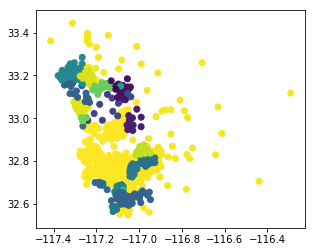

In [35]:
tract_comm[tract_comm['type']=='city'].plot(column='index_right')

In [38]:
B02001.titles.head().T

geoid,14000US06073000100,14000US06073000201,14000US06073000202,14000US06073000300,14000US06073000400
name,14000US06073000100,14000US06073000201,14000US06073000202,14000US06073000300,14000US06073000400
B02001001 Total,2773,2158,4828,4946,3916
Margins for B02001001 Total,185,241,415,405,306
B02001002 Total White alone,2455,1907,4148,4079,3194
Margins for B02001002 Total White alone,214,277,474,402,360
B02001003 Total Black or African American alone,0,33,76,177,52
Margins for B02001003 Total Black or African American alone,12,47,104,138,66
B02001004 Total American Indian and Alaska Native alone,0,8,39,0,12
Margins for B02001004 Total American Indian and Alaska Native alone,12,12,56,12,19
B02001005 Total Asian alone,84,84,368,215,475


In [41]:
tract_comm.head().T

,14000US06073000100,14000US06073000201,14000US06073000202,14000US06073000300,14000US06073000400
id,0,1,2,3,4
name_left,"Census Tract 1, San Diego, CA","Census Tract 2.01, San Diego, CA","Census Tract 2.02, San Diego, CA","Census Tract 3, San Diego, CA","Census Tract 4, San Diego, CA"
B02001001,2773,2158,4828,4946,3916
B02001001e,185,241,415,405,306
B02001002,2455,1907,4148,4079,3194
B02001002e,214,277,474,402,360
B02001003,0,33,76,177,52
B02001003e,12,47,104,138,66
B02001004,0,8,39,0,12
B02001004e,12,12,56,12,19


In [43]:
community_pop = tract_comm[[ 'type','name_right','B02001001']].groupby(['type','name_right']).sum()

B02001001
type             name_right                                    
city             CARLSBAD                              115550.0
                 CHULA VISTA                           244583.0
                 CORONADO                               24852.0
                 DEL MAR                                 4312.0
                 EL CAJON                               89719.0
                 ENCINITAS                              60451.0
                 ESCONDIDO                             131550.0
                 IMPERIAL BEACH                         27117.0
                 LA MESA                                57507.0
                 LEMON GROVE                            22718.0
                 NATIONAL CITY                          56237.0
                 OCEANSIDE                             175117.0
                 POWAY                                  47395.0
                 S.D. COUNTY                           595999.0
                 SAN DIEGO                            1362544.0
                 SAN MARCOS                             80599.0
                 SANTEE                                 60493.0
                 SOLANA BEACH                           12014.0
                 VISTA                                  82110.0
county_community Alpine                                 16163.0
                 Barona                                  2591.0
                 Bonsall                                23975.0
                 County Islands                          3410.0
                 Crest - Dehesa                         18495.0
                 Cuyamaca                                2265.0
                 Descanso                                3234.0
                 Desert                                  3219.0
                 Fallbrook                              36247.0
                 Hidden Meadows                         10261.0
                 Jamul                                  19407.0
...                                                         ...
sd_community     MIDWAY-PACIFIC HIGHWAY                  4693.0
                 MILITARY FACILITIES                    21576.0
                 MIRA MESA                              81051.0
                 MIRAMAR RANCH NORTH                    12316.0
                 MISSION BAY PARK                        4612.0
                 MISSION VALLEY                         15789.0
                 NAVAJO                                 53000.0
                 NCFUA SUBAREA II                        5997.0
                 OCEAN BEACH                            14328.0
                 OTAY MESA                              23723.0
                 OTAY MESA-NESTOR                       61728.0
                 PACIFIC BEACH                          45203.0
                 PACIFIC HIGHLANDS RANCH                14655.0
                 PENINSULA                              41869.0
                 RANCHO BERNARDO                        29884.0
                 RANCHO PENASQUITOS                     37271.0
                 RESERVE                                   23.0
                 SABRE SPRINGS                          15142.0
                 SAN PASQUAL                             1638.0
                 SAN YSIDRO                             29673.0
                 SCRIPPS MIRAMAR RANCH                  16322.0
                 SERRA MESA                             26306.0
                 SKYLINE-PARADISE HILLS                 69638.0
                 SOUTHEASTERN SAN DIEGO,SOUTHEASTERN    58156.0
                 TIERRASANTA                            28167.0
                 TIJUANA RIVER VALLEY                    5016.0
                 TORREY HIGHLANDS                        9956.0
                 TORREY PINES                            8991.0
                 UNIVERSITY                             59873.0
                 UPTOWN                                 40069.0

[93 rows x 1 columns]